# GALAH DR3 - Overview of data needed for analysing GALAH spectra

## Author(s): Sven Buder (SB, WG4)

### History:
200228 SB Created

The aim of this notebook is to provide a step-by-step description of the data that was collected in order to provide all necessary input for the analysis of GALAH spectra as part of GALAH DR3

The identifier of GALAH spectra are called **sobject_id**.

## A) Combining WG3 reduction results with external information

### 1) Go through the stars of "exchange_information/special_targets_sobject_id.fits" to filter out sobject_ids with wrong ra/dec values (dummies, flats, empty fibres during GBS observations etc)

### 2) X-match with Gaia DR2, RUWE, Bailer-Jones, 2MASS, and AllWISE catalogs

From WG3, we get the file with the reduction results, **sobject_iraf_53.fits**.

We then do a coordinate crossmatch **(ra,dec)** via TOPCAT/VizieR Table **2MASS** within a 1 arcsec radius.  
For DR3, we rename the 2MASS identifier to **tmass_id**.

The identifiers (**sobject_id**, **tmass_id**) are uploaded to the Gaia archive, https://gea.esac.esa.int/archive/, (as table with the name "galah_dr3_identifiers").

We want to crossmatch with  
- Gaia DR2 (Brown+2018, http://adsabs.harvard.edu/abs/2018A%26A...616A...1G), 
- RUWE values (Lindegreen+2018, GAIA-C3-TN-LU-LL-124-01),
- Bailer-Jones' distance estimates (Bailer-Jones+2018, http://adsabs.harvard.edu/abs/2018AJ....156...58B),  
- 2MASS (Skrutskie+2006, https://ui.adsabs.harvard.edu/abs/2006AJ....131.1163S/abstract), and
- AllWISE (Cutri_2013, https://ui.adsabs.harvard.edu/abs/2014yCat.2328....0C/abstract)  
via identifiers rather than coordinates.

To do that, we execute the following ADQL query:

```ADQL
SELECT
galah.sobject_id, 
tmass.designation as tmass_id, tmass.j_m, tmass.j_msigcom, tmass.h_m, tmass.h_msigcom, tmass.ks_m, tmass.ks_msigcom, tmass.ph_qual as ph_qual_tmass,
gaia.*, 
calj.r_est, calj.r_lo, calj.r_hi, calj.r_len, calj.result_flag, calj.modality_flag,
gaia_ruwe.ruwe,
wise.designation as wise_id, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error, wise.w3mpro, wise.w3mpro_error, wise.w4mpro, wise.w4mpro_error, wise.cc_flags, wise.ext_flag, wise.var_flag, wise.ph_qual as ph_qual_wise
FROM 
    gaiadr2.gaia_source as gaia
LEFT OUTER JOIN
	external.gaiadr2_geometric_distance as calj
	ON gaia.source_id = calj.source_id
LEFT OUTER JOIN
    gaiadr2.ruwe AS gaia_ruwe
    ON gaia.source_id = gaia_ruwe.source_id
LEFT OUTER JOIN
    gaiadr2.allwise_best_neighbour AS allwisexmatch
    ON gaia.source_id = allwisexmatch.source_id
LEFT OUTER JOIN
    gaiadr1.allwise_original_valid AS wise
    ON allwisexmatch.allwise_oid = wise.allwise_oid
LEFT OUTER JOIN
    gaiadr2.tmass_best_neighbour AS tmassxmatch
    ON gaia.source_id = tmassxmatch.source_id
LEFT OUTER JOIN
    gaiadr1.tmass_original_valid AS tmass
    ON tmassxmatch.tmass_oid = tmass.tmass_oid
INNER JOIN
	user_sbuder.galah_dr3_identifiers as galah
	ON galah.tmass_id = tmass.designation
```

### 3) Include nu_max and delta_nu values from Stello+ (priv communication)

With the table at hand, we do a crossmatch the star that have measured nu_max and delta_nu values.  
We got these from Dennis Stello (see emails from 190103 and 190107)

### 4) Exchange values for stars that have better parallax information from HIPPARCOS and more reliable K_S magnitudes from Heiter+2015 (http://adsabs.harvard.edu/abs/2015A%26A...582A..49H)

These can be found in "exchange_information/sobject_GBS_extended.fits" and have been edited by hand

### 5) Include x-match with SkyMapper DR3

This was performed by Chris Onken based on Gaia DR2 source_id

# B) Plot the uncertainty of parallax and two CMDs

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
from astropy.table import Table
from scipy.io.idl import readsav
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [2]:
data = Table.read('sobject_iraf_53_2MASS_GaiaDR2_WISE_PanSTARRSDR1_BailerJones_K2seis_small.fits')

In [ ]:
# select stars with finite parallax and Bailer-Jones distance

finite_parallax = (
    np.isfinite(data['parallax']) & 
    (data['parallax']!=0.) & 
    np.isfinite(data['r_est'])
    )

# Only a small portion of the parallaxes are bad. We are thus stacking those with uncertainties above 15\% at the end
plx_uncertainty = np.array(100.*np.abs(data['parallax_error'][finite_parallax]/data['parallax'][finite_parallax]))
stack_at_end = plx_uncertainty.clip(max=15);

In [ ]:
def plot_parallax_quality_and_cmds():
    """
    We plot 3 panels
    a) parallax quality, with bad measurments stacked at 15\% uncertainty
    b) a CMD for Gaia colors
    c) a CMD for 2MASS colors
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    
    # Parallax quality
    ax1.hist(
        plx_uncertainty,rasterized=True,
        bins=np.arange(0,15.0,0.4),color=willi_blau,histtype='stepfilled',ec='k',zorder=2
        )
    ax1.hist(
        stack_at_end,rasterized=True,
        bins=np.arange(0,15.3,0.4),color='r',histtype='stepfilled',ec='k',zorder=1
        )
    ax1.set_xlim(-0.2,15.3)
    ax1.set_ylim(0,95000)
    ax1.set_ylabel('Nr. Spectra')
    ax1.set_xlabel(r'$\varpi$ uncertainty [\%]')
    ax1.text(0.8,0.9,str(len(stack_at_end[stack_at_end<15]))+' $\leq$ 15\%',c=willi_blau,transform=ax1.transAxes,ha='right')
    ax1.text(0.8,0.8,str(len(stack_at_end[stack_at_end==15]))+' $>$ 15\%',c='r',transform=ax1.transAxes,ha='right')
    ax1.text(0.8,0.7,'Median: '+"{:.1f}".format(np.median(plx_uncertainty))+r'\%',c='k',transform=ax1.transAxes,ha='right')
    
    p2, x2, y2, s2 = ax2.hist2d(
        data['bp_rp'][finite_parallax],
        data['phot_g_mean_mag'][finite_parallax]-5*np.log10(data['r_est'][finite_parallax]/10.),
        bins=(np.linspace(-0.75,4.5,100),np.linspace(-6,13,100)),
        cmin=1,cmap=parula,rasterized=True,
        norm=LogNorm()
        )
    ax2.set_xlim(-0.75,4.5)
    ax2.set_ylim(13,-6)
    ax2.set_xlabel(r'$G_\text{BP} - G_\text{RP}$')
    ax2.set_ylabel(r'$G - 5\cdot \log_{10}(\frac{r_\text{est}}{10})$')
    
    p3, x3, y3, s3 = ax3.hist2d(
        data['j_m'][finite_parallax]-data['ks_m'][finite_parallax],
        data['ks_m'][finite_parallax]-5*np.log10(data['r_est'][finite_parallax]/10.),
        bins=(np.linspace(-1,3.5,200),np.linspace(-11,11,200)),
        cmin=1,cmap=parula,rasterized=True,
        norm=LogNorm()
        )
    ax3.set_xlim(-0.35,1.65)
    ax3.set_ylim(9,-9)
    ax3.set_xlabel(r'$J - K_\text{S}$')
    ax3.set_ylabel(r'$K_\text{S} - 5\cdot \log_{10}(\frac{r_\text{est}}{10})$')

    fig.subplots_adjust(right=0.8)
    plt.tight_layout(h_pad=1)
    cbar_ax = fig.add_axes([1.0, 0.22, 0.01, 0.7])
    c3=fig.colorbar(s3, cax=cbar_ax)
    c3.set_label('Nr. Spectra')
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.75)
    ax1.text(0.025, 0.975, 'a)', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ax2.text(0.025, 0.975, 'b)', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ax3.text(0.025, 0.975, 'c)', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return(fig)

print(str(len(stack_at_end[stack_at_end<15])),"{:.0f}".format(100*len(stack_at_end[stack_at_end<15])/len(stack_at_end))+'%',' with plx uncertainty <= 15%')
print(str(len(stack_at_end[stack_at_end==15])),"{:.0f}".format(100*len(stack_at_end[stack_at_end==15])/len(stack_at_end))+'%',' with plx uncertainty > 15%')
print('Median: '+"{:.1f}".format(np.median(plx_uncertainty)))

print('NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!')

fig = plot_parallax_quality_and_cmds()
fig.savefig('figures/plot_parallax_quality_and_cmds.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/plot_parallax_quality_and_cmds.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/plot_parallax_quality_and_cmds.png',dpi=200,bbox_inches='tight')

NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3530: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


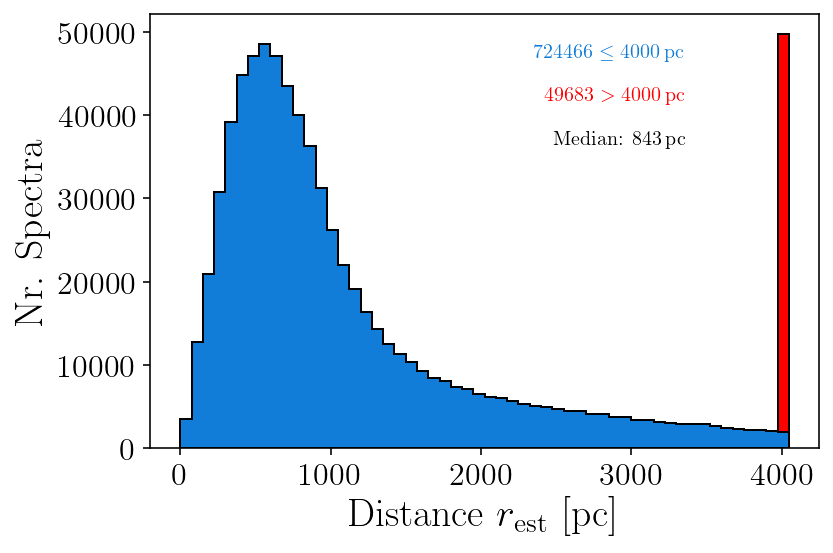

In [38]:
def plot_distances():
    """
    We plot the distribution of distances
    """
    
    fig, (ax1) = plt.subplots()

    dist = data['r_est']
    dist_stacked = dist.clip(max = 4000)
    dist_stacked[dist_stacked<4000] = -1
    dist_stacked[dist_stacked==4000] = 4001
    
    # Distance
    ax1.hist(
        dist_stacked,rasterized=True,
        bins=np.arange(0,4100,75),color='r',histtype='stepfilled',ec='k',zorder=2
        )
    ax1.hist(
        dist,rasterized=True,
        bins=np.arange(0,4100,75),color=willi_blau,histtype='stepfilled',ec='k',zorder=2
        )
    #ax1.set_xlim(-0.2,15.3)
    ax1.set_ylabel('Nr. Spectra')
    ax1.set_xlabel(r'Distance $r_\text{est}$ [pc]')
    ax1.text(0.8,0.9,str(len(dist[dist<4000]))+' $\leq 4000\,\mathrm{pc}$',c=willi_blau,transform=ax1.transAxes,ha='right')
    ax1.text(0.8,0.8,str(len(dist_stacked[dist_stacked==4000+1]))+' $> 4000\,\mathrm{pc}$',c='r',transform=ax1.transAxes,ha='right')
    ax1.text(0.8,0.7,r'Median: $'+"{:.0f}".format(np.nanmedian(dist))+r'\,\mathrm{pc}$',c='k',transform=ax1.transAxes,ha='right')

    return fig

print('NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!')

fig = plot_distances()
fig.savefig('figures/distance.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/distance.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/distance.png',dpi=200,bbox_inches='tight')

NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


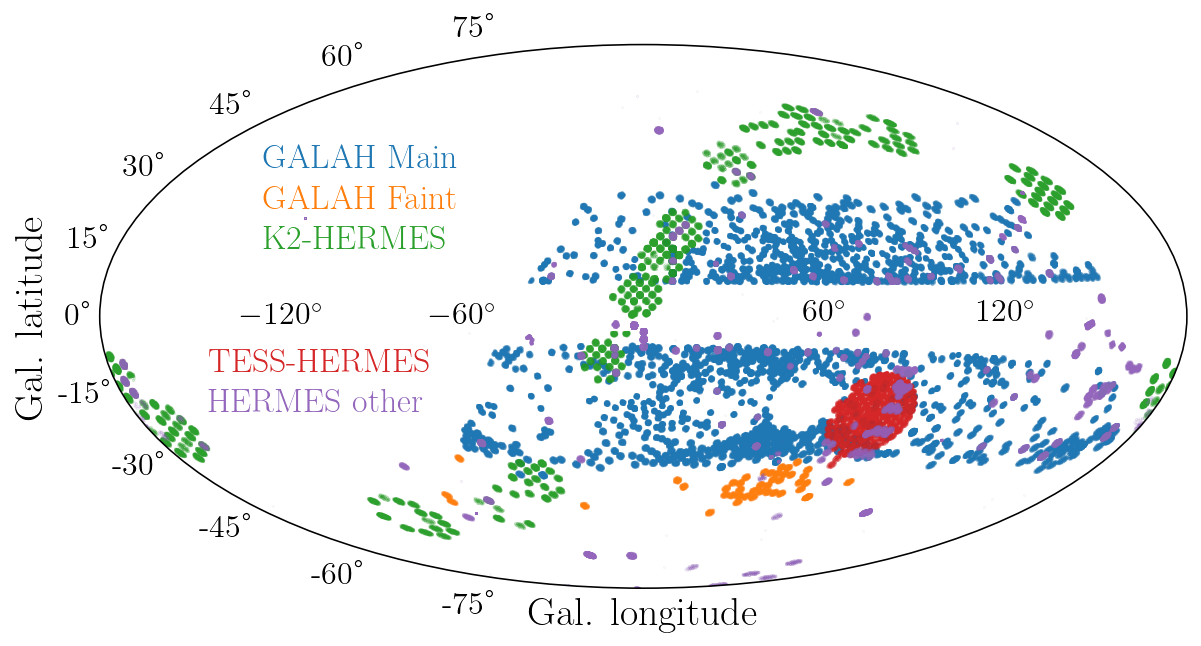

In [37]:
def plot_l_b_colored():
    """
    We plot the distribution spectra in (l,b), colored by the program
    """
    
    fig = plt.figure(figsize=(11,5))
    plt.grid(True)
    ax = plt.subplot(111, projection="aitoff");

    main = ((data['field_id'] >= 0) & (data['field_id'] < 6546))
    faint = ((data['field_id'] >= 6831) & (data['field_id'] < 7117))
    k2 = ((data['field_id'] >= 6546) & (data['field_id'] < 6831))
    tess = ((data['field_id'] >= 7117) & (data['field_id'] < 7366))
    other = ((data['field_id'] >=  7366) | (data['field_id'] < 0))
    
    for each_id, each_subset in enumerate([main, faint, k2, tess,other]):
        
        c_gal = SkyCoord(ra=data['ra'][each_subset], dec=data['dec'][each_subset], frame='icrs')
        c_gal_icrs = c_gal.icrs
        l_rad = c_gal_icrs.galactic.l.wrap_at(180 * u.deg).radian
        b_rad = c_gal_icrs.galactic.b.radian

        s1=ax.scatter(-l_rad, b_rad,s=0.005,rasterized=True,alpha=0.5)
    ax.set_xticks([-120/360*2*np.pi,-60/360*2*np.pi,60/360*2*np.pi,120/360*2*np.pi])
    ax.set_xticklabels([r'$-120^\circ$',r'$-60^\circ$',r'$60^\circ$',r'$120^\circ$'],va='center')
    ax.set_xlabel('Gal. longitude')
    ax.set_ylabel('Gal. latitude')
    
    ax.text(0.15,0.775,'GALAH Main',c='C0',transform=ax.transAxes,fontsize=17)
    ax.text(0.15,0.7,'GALAH Faint',c='C1',transform=ax.transAxes,fontsize=17)
    ax.text(0.15,0.625,'K2-HERMES',c='C2',transform=ax.transAxes,fontsize=17)
    ax.text(0.1,0.4,'TESS-HERMES',c='C3',transform=ax.transAxes,fontsize=17)
    ax.text(0.1,0.325,'HERMES other',c='C4',transform=ax.transAxes,fontsize=17)
    
    return fig
print('NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!')

fig = plot_l_b_colored()
fig.savefig('figures/lb_overview_colored.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/lb_overview_colored.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/lb_overview_colored.png',dpi=200,bbox_inches='tight')

NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


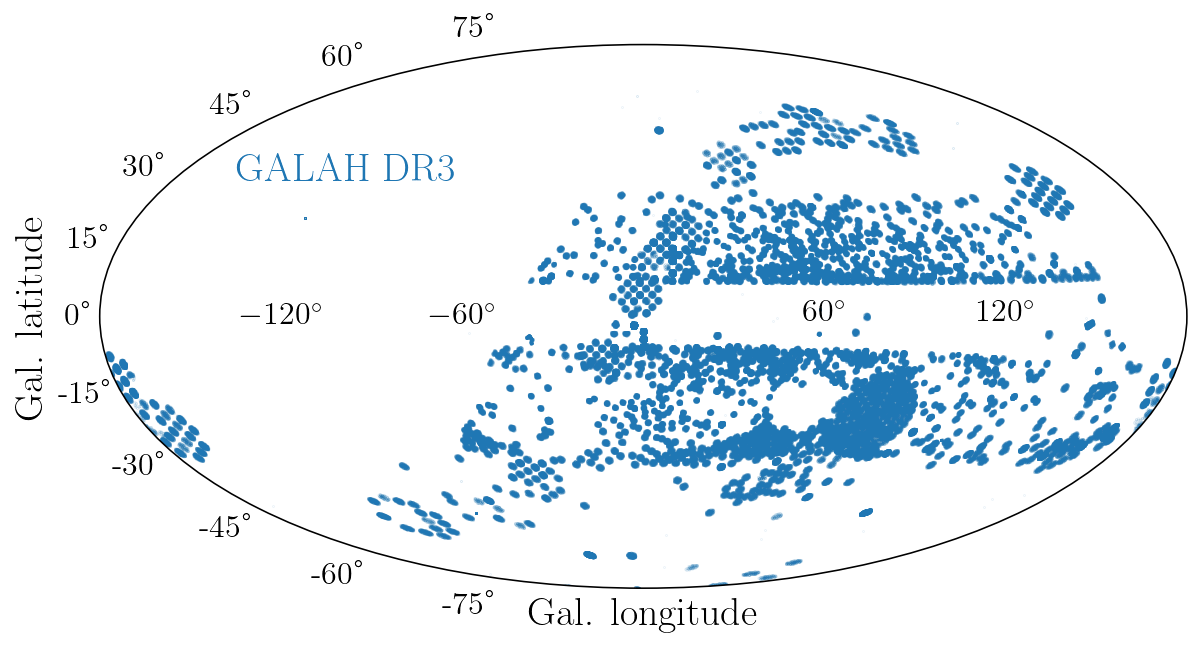

In [33]:
def plot_l_b_all():
    """
    We plot the distribution spectra in (l,b), colored by the program
    """
    
    fig = plt.figure(figsize=(11,5))
    plt.grid(True)
    ax = plt.subplot(111, projection="aitoff");

    main = np.isfinite(data['ra'])
    
    for each_id, each_subset in enumerate([main]):
        
        c_gal = SkyCoord(ra=data['ra'][each_subset], dec=data['dec'][each_subset], frame='icrs')
        c_gal_icrs = c_gal.icrs
        l_rad = c_gal_icrs.galactic.l.wrap_at(180 * u.deg).radian
        b_rad = c_gal_icrs.galactic.b.radian

        s1=ax.scatter(-l_rad, b_rad,s=0.005,rasterized=True,alpha=0.5)
    ax.set_xticks([-120/360*2*np.pi,-60/360*2*np.pi,60/360*2*np.pi,120/360*2*np.pi])
    ax.set_xticklabels([r'$-120^\circ$',r'$-60^\circ$',r'$60^\circ$',r'$120^\circ$'],va='center')
    ax.set_xlabel('Gal. longitude')
    ax.set_ylabel('Gal. latitude')
    
    ax.text(0.125,0.7,'GALAH DR3',c='C0',transform=ax.transAxes,fontsize=20)
    
    return fig
print('NB: This includes all stars that are part of the sobject_iraf_53 input with Gaia matches. Not all of these stars have been processed by WG4!')

fig = plot_l_b_all()
fig.savefig('figures/lb_overview_all.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/lb_overview_all.pdf',dpi=200,bbox_inches='tight')
fig.savefig('../release_paper/figures/lb_overview_all.png',dpi=200,bbox_inches='tight')